# Explore
### A notebook for my initial explorations of the PCWG CESM/COSP outputs for satellite observation comparisons.
##### Initialized by Drew Camron 01/2018
---

In [1]:
%matplotlib inline
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='talk')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:57606 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
# Working directory
indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
        'cesm112LENS_FAMIPC5.f09_f09.001_cosp1.4_opaq_prec/atm/hist/')

Jen's data in this directory feature
* `h0` history fields of monthly mean general outputs featuring COSP diagnostics
* `h1` history fields of daily **(instantaneous?)** outputs of just cloud quantities

from 2006 through 2015. So, let's look at a year of monthly data and practice narrowing our analysis to Greenland!

In [4]:
# Reading in a year of monthly mean data and attempt to slice to Greenland bounds
ds = xr.open_mfdataset(indir+'cesm112LENS_FAMIPC5.f09_f09.001_cosp1.4_opaq_prec.cam.h0.2006-*.nc')
ds = ds.sel(lat=slice(55, 90)).sel(lon=slice(270, 360))
ds

<xarray.Dataset>
Dimensions:          (cosp_dbze: 15, cosp_ht: 40, cosp_scol: 250, cosp_sr: 15, cosp_sza: 5, ilev: 31, lat: 38, lev: 30, lon: 72, nbnd: 2, slat: 191, slon: 288, time: 12)
Coordinates:
  * lev              (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev             (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 ...
  * cosp_ht          (cosp_ht) float64 240.0 720.0 1.2e+03 1.68e+03 2.16e+03 ...
  * cosp_sr          (cosp_sr) float64 0.605 2.1 4.0 6.0 8.5 12.5 17.5 22.5 ...
  * cosp_sza         (cosp_sza) float64 0.0 15.0 30.0 45.0 60.0
  * cosp_scol        (cosp_scol) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * cosp_dbze        (cosp_dbze) float64 -47.5 -42.5 -37.5 -32.5 -27.5 -22.5 ...
  * lat              (lat) float64 55.13 56.07 57.02 57.96 58.9 59.84 60.79 ...
  * lon              (lon) float64 270.0 271.2 272.5 273.8 275.0 276.2 277.5 ...
  * slat             (slat) float64 -89.53 -88.59 -87.64 -86.7 -85.76 -84.82 ...
  * slon       

Being new to this, I'll take a look at CLDTOT *vertically-integrated total cloud fraction*.

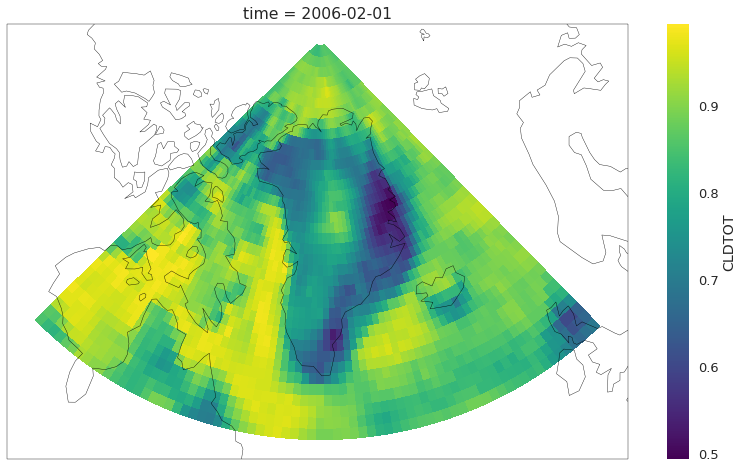

In [6]:
f, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
p = ds['CLDTOT'].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())
cl = ax.coastlines()